<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch5_SystemsOfODEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Systems of ODEs, and higher-order ODEs

Let's solve the **pendulum** equation
$$u'' + \omega_0^2\sin(u)=0,\quad u(0)=0.2, u'(0) = 0$$
where $\omega_0 = \sqrt{\frac{g}{L}}$. This models the angular displacement $u$ of a pendulum of length $L$ in Earth's gravitational field. This is not a first-order ODE, it is a **second-order** ODE.

As we did in the [notes](https://github.com/stephenbeckr/numerical-analysis-class/blob/master/Notes/Ch5_SystemsOfODEs.pdf), we can convert this to a system of **two** **first-order** ODEs.
\begin{align}
u' &= v \\
v' &= -\omega_0^2\sin(u) \\
u(0) &= 0.2 \\
v(0) &= 0 
\end{align}
or more generally
\begin{align}
u_1' &= u_2 \\
u_2' &= -\omega_0^2\sin(u_1) \\
u_1(0) &= 0.2 \\
u_2(0) &= 0 
\end{align}

Note that if we make the small angle approximation, then the ODE $u'' + \omega_0^2 u = 0$ with $u'(0)=0$ has the closed-form solution
$$u(t) = u(0)\cos(\omega_0 t).$$

In [2]:
import numpy as np
from numpy import sin, cos, exp
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate # use for scipy.interpolate.CubicHermiteSpline
from scipy.integrate import solve_ivp
mpl.rcParams["figure.figsize"] = [8,6] # or 7, 4 or 10,8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'cm'

### Setup the RHS of the Pendulum ODE, call Scipy solver

In [3]:
omega = 2.
omegaSq = omega**2
def f_pendulum(t,uVector):
  # The RHS for the pendulum equation; this does not depend on t
  u, v = uVector
  f0 = v
  f1 = -omegaSq*np.sin(u)
  return [f0,f1]

tspan = [0,10] # solve for 10 seconds
y0    = [.2, 0]
ivp_soln = solve_ivp( f_pendulum, tspan, y0, dense_output=True )
y     = ivp_soln.sol

y_linearized = lambda t : y0[0]*np.cos(omega*t)

Let's plot it.  Is the solution similar to the closed form solution of the approximate/simpler equation?

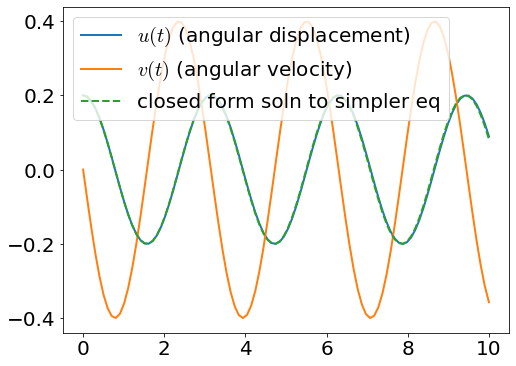

In [4]:
t = np.linspace(*tspan,100)

plt.plot(t,y(t).T);
plt.plot(t,y_linearized(t),'--')
plt.legend(['$u(t)$ (angular displacement)','$v(t)$ (angular velocity)','closed form soln to simpler eq']);

Yes, the closed form solution to the simpler equation looks quite close. To see the differences better, let's plot the differences

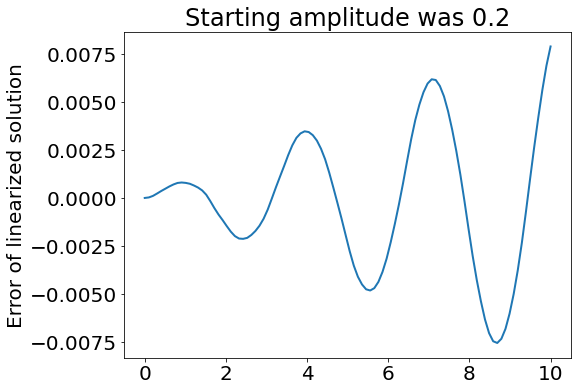

In [5]:
t = np.linspace(*tspan,100)

plt.plot(t,y(t)[0].T - y_linearized(t) );
plt.ylabel('Error of linearized solution');
plt.title(f'Starting amplitude was {y0[0]}');

What if we do the same as above, for a larger starting amplitude? This should make the small angle approximation less valid

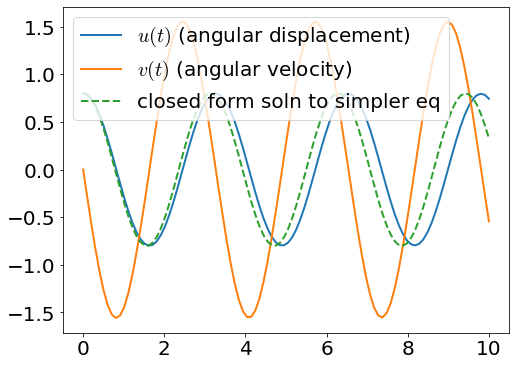

In [6]:
y0    = [.8, 0]
ivp_soln = solve_ivp( f_pendulum, tspan, y0, dense_output=True )
y     = ivp_soln.sol

y_linearized = lambda t : y0[0]*np.cos(omega*t)

plt.plot(t,y(t).T);
plt.plot(t,y_linearized(t),'--')
plt.legend(['$u(t)$ (angular displacement)','$v(t)$ (angular velocity)','closed form soln to simpler eq']);

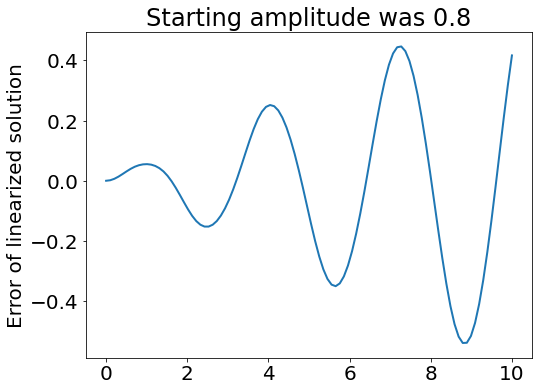

In [7]:
plt.plot(t,y(t)[0].T - y_linearized(t) );
plt.ylabel('Error of linearized solution');
plt.title(f'Starting amplitude was {y0[0]}');

### Now let's define our own Euler's method
This the same code as last demo, but we modfied line 11, 20 and 22. These are just programming details

In [8]:
def forward_Euler( f, tspan,y0, h=0.1, dense_output=False):
  """ Solve IVP y' = f(t,y) on a <= t <= b, y(a)=y0, via improved Euler with stepsize h
  This code has NOT been tested to work with systems.
  Returns tHist, wHist where wHist[i] approximates y( tHist[i] )
  """
  if len(tspan) is not 2:
    raise ValueError("tspan must be array of length 2")
  a, b = tspan[0], tspan[1]  
  # Initialize
  t    = a
  w    = np.asarray(y0)  # Changed this code
  # Update history
  tHist = [t]
  wHist = [w]  # w[i] approximates y( t[i] )
  dydtHist = []
  # Loop
  while t < b :
    tNext = min(t+h,b)  # don't go too far
    hh    = tNext - t   # hh is just h except perhaps at the last time step
    dydt  = np.asarray(f(t,w))   # changed this code
    # w    += hh*dydt     # doesn't play well with np.arrays
    w     = w + hh*dydt
    t     = tNext
    # Update history
    tHist.append(t)
    wHist.append(w)
    dydtHist.append(dydt)

  dydtHist.append( f(t,w) )# lagged

  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(tHist,wHist,dydtHist)
    return np.array(tHist), np.array(wHist), sol
  else:  
    return np.array(tHist), np.array(wHist)

and let's run it and see how it works

In [9]:
h = 0.5
tHist, wHist, yEuler = forward_Euler( f_pendulum, tspan, y0, h = h, dense_output=True )

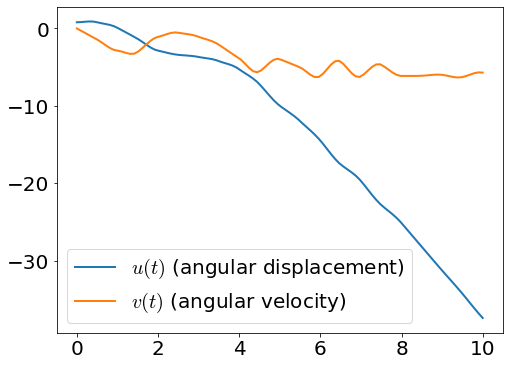

In [10]:
t = np.linspace(*tspan,100)
plt.plot( t, yEuler(t) );
#plt.plot( tHist, wHist[:,0] ); # simple

plt.legend(['$u(t)$ (angular displacement)','$v(t)$ (angular velocity)']);

Well, for a large stepsize, we get a terrible answer. Perhaps not so unexpected. Let's do a smaller stepsize then

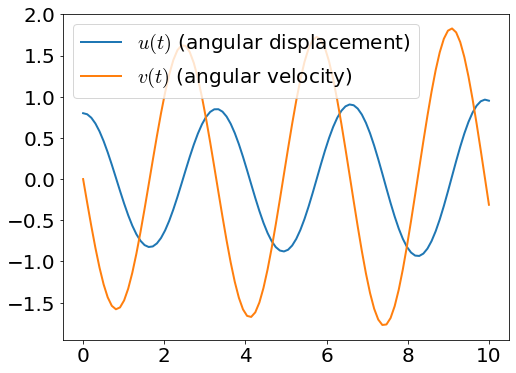

In [11]:
h = 0.01
tHist, wHist, yEuler = forward_Euler( f_pendulum, tspan, y0, h = h, dense_output=True )

t = np.linspace(*tspan,100)
plt.plot( t, yEuler(t) );

plt.legend(['$u(t)$ (angular displacement)','$v(t)$ (angular velocity)']);

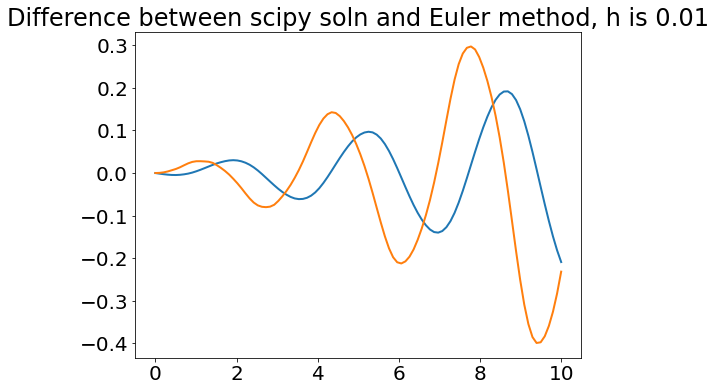

In [12]:
plt.plot( t, y(t).T - yEuler(t) );
plt.title(f'Difference between scipy soln and Euler method, h is {h}');

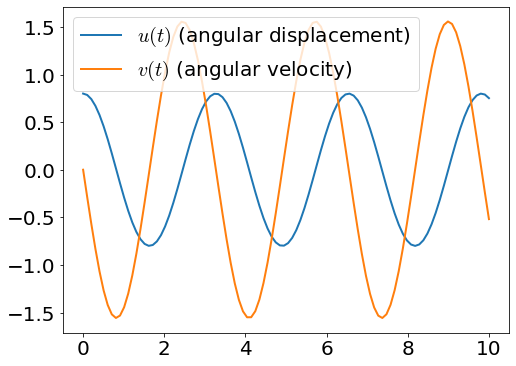

In [15]:
h = 1e-5
tHist, wHist, yEuler = forward_Euler( f_pendulum, tspan, y0, h = h, dense_output=True )

t = np.linspace(*tspan,100)
plt.plot( t, yEuler(t) );

plt.legend(['$u(t)$ (angular displacement)','$v(t)$ (angular velocity)']);

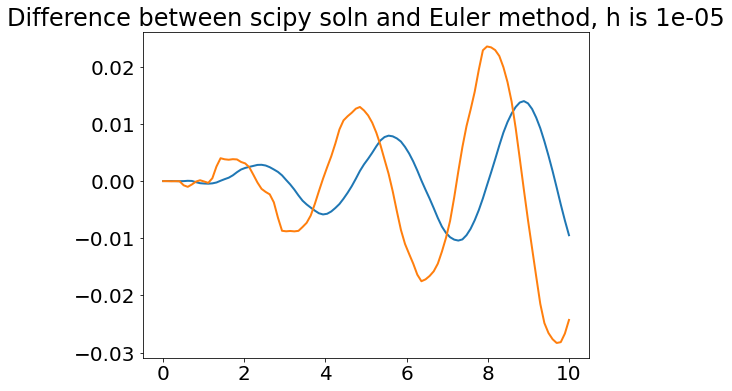

In [14]:
plt.plot( t, y(t).T - yEuler(t) );
plt.title(f'Difference between scipy soln and Euler method, h is {h}');